In [1]:
import matplotlib
matplotlib.rc("lines", linewidth=2)
matplotlib.rc('text', usetex=True)
matplotlib.rc("font", family="serif", serif='cmr10')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxpower import *

In [3]:
periods_per_hour = 60
T = 24*periods_per_hour
len_interval=1/periods_per_hour
alpha = .02*len_interval
gamma = .5*len_interval
p_load = np.array([
  0.51474725,
  0.47401232,
  0.46804122,
  0.47140148,
  0.51735674,
  0.63193182,
  0.80121667,
  0.74983225,
  0.71661753,
  0.74235491,
  0.73155551,
  0.70865584,
  0.67823632,
  0.66232903,
  0.68180769,
  0.77185203,
  0.94758236,
  1.0033142 ,
  1.02072008,
  1.16801152,
  1.30939302,
  1.11789843,
  0.8708018 ,
  0.62076654 ])
N = p_load.size
p_load = np.interp(np.arange(T), np.linspace(0,T,N), p_load)
p_load = p_load / np.max(p_load)*2

In [4]:
load = FixedLoad(power=p_load, name='fixed load')
gen = Generator(power_max=6, alpha=alpha, beta=0, gamma=gamma, len_interval=len_interval, name="generator")
deferrable = DeferrableLoad(time_start=8*periods_per_hour, time_end=20*periods_per_hour, energy=30, 
                            power_max=5, len_interval=len_interval, name="def. load")
storage = Storage(discharge_max=2, charge_max=2, energy_max=5, len_interval=len_interval, name='storage')
net = Net([gen.terminals[0], deferrable.terminals[0],
           load.terminals[0], storage.terminals[0]])

network = Group([gen, deferrable, load, storage], [net])
results = network.optimize(time_horizon=T, solver='ECOS')
print(results)

/home/nick/software/anaconda3/lib/python3.5/site-packages/cvxpy-1.0.8-py3.5-linux-i686.egg/cvxpy/problems/problem.py:614: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
/home/nick/software/anaconda3/lib/python3.5/site-packages/cvxpy-1.0.8-py3.5-linux-i686.egg/cvxpy/problems/problem.py:615: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


Status: optimal
Terminal                  Power
--------                  -----
fixed load[0]              1.18
generator[0]              -2.43
def. load[0]               1.25
storage[0]                 0.00

Net                       Price
---                       -----
Net                      0.0016

Device                  Payment
------                  -------
generator                 -6.46
fixed load                 2.83
storage                   -0.36
def. load                  3.99

Power and price are averages over the time horizon. Payment is total.



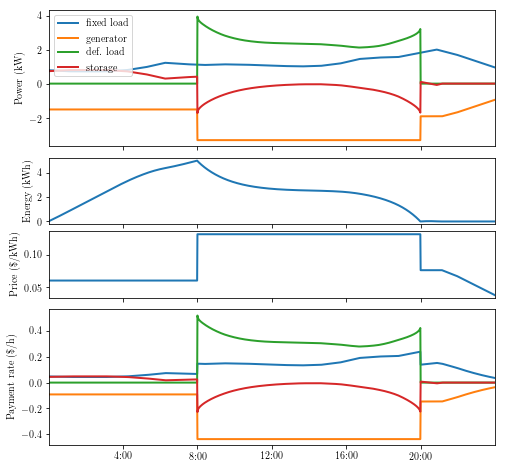

In [9]:
plt.figure(figsize=(8,8))

price_per_kw = list(network.results.price.items())[0][1]
price_per_kwh =  price_per_kw / len_interval

ticks = [t*periods_per_hour for t in [4,8,12,16,20]]
plt.subplot(311)
i = network.results.power.items()
for (d, pd) in i:
    plt.plot(pd)
plt.legend([d[0].name for (d,pd) in i], loc='upper left')
plt.ylabel("Power (kW)")
plt.xlim([0,T])
#.ylim([-2,4.5])
plt.xticks(ticks,('', '', '', '', ''))

plt.subplot(613)
plt.plot(storage.energy.value)
plt.ylabel("Energy (kWh)")
plt.xlabel("time of day")
plt.xlim([0,T])
plt.xticks(ticks,('', '', '', '', ''))

plt.subplot(614)
plt.plot(price_per_kwh)
plt.ylabel("Price (\$/kWh)")
plt.xlim([0,T])
plt.xticks(ticks,('', '', '', '', ''))

plt.subplot(313)
#plt.plot(list(network.results.price.items())[0][1]/len_interval)
i = network.results.power.items()
for (d, pd) in i:
    plt.plot(pd * price_per_kwh)
plt.ylabel("Payment rate (\$/h)")
plt.xlim([0,T])
#plt.legend([d[0].name for (d,pd) in i], loc='upper left')

plt.subplots_adjust(hspace=.1)

plt.xticks(ticks, ('4:00', '8:00', '12:00', '16:00', '20:00'))

plt.savefig("home_energy_results.pdf")